---
title: "fast.ai Chapter 8: Collaborative Filter Deep Dive"
date: '2021-06-04'
author: "Vishal Bakshi"
categories:
    - deep learning
    - python
freeze: true
---

In [ ]:
#| include: false
!pip install -Uqq fastai 
!pip install -Uqq fastcore

from IPython.display import HTML
from fastai.vision.all import *

from google.colab import drive
drive.mount('/content/gdrive')

import fastai
fastai.__version__ == '2.3.1'

Here's the video walkthrough of this notebook

In [2]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/MgRNk9DUqN8" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

![Scatter plot for a 2-component Principal Component Analysis](collaborative-filter-plot.png)

In this notebook, I'll walkthrough the code and concepts introduced in Chapter 8 of the fastai textbook. This chapter explores the various ways fastai can handle a collaborative filtering problem.

## What is Collaborative Filtering?

In a situation where two variables have some numeric relationship, such as **users** rating **movies**, collaborative filtering is a solution for predicting ratings that are blank, based on existing data. 

A machine learning model for collaborative filtering implicitly learns the answers to the following questions:

- What types of movies do users like?
- What are characteristics of each movie?



### Latent Factors

For the movie rating example, latent factors are the "types of movies" users like and "characteristics" of each movie. Latent factors are not explicitly categorical, they are numeric values, but they represent the implicit categories of each variable. 

The reason that they are implicit categories, is that the model learns the ideal latent factors as it trains on the dataset, observing patterns between users and their movie ratings. 

## MovieLens 100K Dataset

The dataset used to train the collaborative filtering model is a subset (100,000 rows in length) of the [full MovieLens dataset](https://oreil.ly/gP3Q5) which is 25 million rows.

In [ ]:
# a first look at the data
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

The dataset lists users, movies, ratings and a timestamp.

In [ ]:
# load the data into a DataFrame
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Before we get into the training, I want to familiarize myself with how the data is structured. There are 943 unique users and 1682 unique movies.

In [ ]:
# how many unique users and movies are there?
len(ratings['user'].unique()), len(ratings['movie'].unique())

(943, 1682)

The movie IDs are a consecutive range from 1 to 1682 and the user IDs are a consecutive range from 1 to 943. The movie ratings range from 1 to 5.

In [ ]:
# are movie IDs consecutive?
(ratings['movie'].sort_values().unique() == np.array(range(1,1683))).sum()

1682

In [ ]:
# are user IDs consecutive?
(ratings['user'].sort_values().unique() == np.array(range(1,944))).sum()

943

In [ ]:
# what is the range of ratings?
ratings['rating'].min(), ratings['rating'].max()

(1, 5)

To visualize the problem we are trying to solve with collaborative filtering the book recommended that we observe a cross-tabulation of the data because then we can see that what we are trying to predict are the null values between user and movie, and what we are training our model on are the non-null ratings in the dataset. 

The model will learn something about user 2 and movie 2 in order to predict what rating that user would give that movie. That "something" the model will learn are the latent factors for users and latent factors for movies.

In [ ]:
# view crosstab of users and movies with rating values
ct = pd.crosstab(ratings['user'], ratings['movie'], ratings['rating'],aggfunc='mean')
ct

movie,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Instead of movie IDs, we can get the movie titles into a DataFrame and add that column to our `ratings` DataFrame by merging the two.

The movie titles are in the `u.item` file, which is pipe-delimited, with latin-1 encoding. The `u.item` file has 24 columns, but we only want the first two which have the `movie` id and the `title`.

In [ ]:
# get movie titles
movies = pd.read_csv(
    path/'u.item', 
    delimiter='|', 
    encoding='latin-1', 
    usecols=(0,1), 
    names=('movie', 'title'), 
    header=None)

movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


The `movies` DataFrame and the `ratings` DataFrame are merged using the `movie` column as the key to match title in `movies` to `movie` ID in `ratings`. By default, pandas uses as the `key` whichever column name exists in both DataFrames.


In [ ]:
# get the user ratings by title
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


Does this change the uniqueness of the data? Yes it actually does! There are 1682 unique movie IDs but there are only 1664 unique movie titles. 18 movies have associated with it duplicate titles.


In [ ]:
# how many unique titles and movies are there?
len(ratings['title'].unique()), len(ratings['movie'].unique())

(1664, 1682)

The `.duplicated` DataFrame method takes a list of columns for the `subset` parameter, finds values in those columns that are duplicated, and returns a boolean Series with a `True` value at indexes with duplicates. I use that as a mask and pass it to the `movies` DataFrame to view those duplicate titles.

In [ ]:
# 18 movies have duplicate titles
movies[movies.duplicated(subset=['title'])]

,movie,title
267,268,Chasing Amy (1997)
302,303,Ulee's Gold (1997)
347,348,Desperate Measures (1998)
499,500,Fly Away Home (1996)
669,670,Body Snatchers (1993)
679,680,Kull the Conqueror (1997)
864,865,"Ice Storm, The (1997)"
880,881,Money Talks (1997)
1002,1003,That Darn Cat! (1997)
1256,1257,"Designated Mourner, The (1997)"


fastai has a built-in constructor for DataLoaders specific to collaborative filtering. I pass it the ratings DataFrame, specify that the items are the titles, and that I want 64 rows in each batch.

In [ ]:
# create DataLoaders
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,297,Indian Summer (1996),4
1,934,Grease (1978),4
2,846,Money Train (1995),2
3,479,Crumb (1994),3
4,499,Local Hero (1983),4
5,455,"Adventures of Priscilla, Queen of the Desert, The (1994)",3
6,943,Rumble in the Bronx (1995),4
7,374,Dead Poets Society (1989),1
8,533,"Deer Hunter, The (1978)",3
9,846,Vanya on 42nd Street (1994),2


### Matrices for Latent Factors

We need the model to find relationships between users and movies. And we need to give the model something concrete and numeric to represent those relationships. We will give it latent factor matrices.

In this example, they have chosen to use 5 latent factors for movies and 5 latent factors for users. We represent these latent factors by creating a matrix of random values.

The user latent factors will have 944 rows, one for each user including a null user, and 5 columns, one for each latent factor. The movies latent factors will have 1665, one for each movie including a null movie, and 5 columns.


In [ ]:
# user and title classes contain '#na#'
L(dls.classes['title']),L(dls.classes['user'])

((#1665) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'...],
 (#944) ['#na#',1,2,3,4,5,6,7,8,9...])

In [ ]:
# define dimensions for users and movies latent factor matrices
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5
n_users, n_movies, n_factors

(944, 1665, 5)

In [ ]:
# build users and movies latent factor matrices
user_factors = torch.randn(n_users,n_factors)
movie_factors = torch.randn(n_movies, n_factors)
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

### Embeddings instead of One Hot Encoded Matrix Multiplication

Okay so how do we use these latent factor matrices? 

For each row in our batch, we have a user ID and a movie ID. We need to get the latent factors for each of those and calculate the dot product, in order to predict our rating. As it adjusts the latent factors during the training loop, the predictions will get better.

I'll grab one batch from the `dls` DataLoaders object and illustrate an example prediction calculation. Each independent variable, `x`, is a tensor with `[user, movie]`. Each dependent variable, `y`, is a tensor with `[rating]`.

In [ ]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [ ]:
x[0], y[0]

(tensor([466, 614]), tensor([3], dtype=torch.int8))

In [ ]:
type(x[0]), type(y[0])

(torch.Tensor, torch.Tensor)

I determined the order of the x values by looking at the maximum value in each column, specifying axis=0. The movie IDs go up to 1644, so a max value of 1608 means that the movie is the second value in each tensor.

In [ ]:
x.max(axis=0)

torch.return_types.max(values=tensor([ 935, 1642]), indices=tensor([24,  3]))

I get the latent factors for the user and movie in the first batch item.


In [ ]:
u = user_factors[x[0][0]]
u

tensor([-0.6595, -0.3355,  1.0491,  1.1764,  0.8750])

In [ ]:
m = movie_factors[x[0][1]]
m

tensor([-0.1751, -0.5016,  0.6298,  0.2370, -0.7902])

I calculate the dot product of the two vectors, which is the sum of the element-wise product.

In [ ]:
pred = (u * m).sum()
pred

tensor(0.5320)

I pass it through `sigmoid_range` to get a value between 0 and 5. Sigmoid outputs a value between 0 and 1, and `sigmoid_range` scales and shifts that function to fit the specified range. The output is the prediction for the rating that this user would give this movie.

In [ ]:
pred = sigmoid_range(pred, 0, 5)
pred

tensor(3.1497)

Since the prediction and the target are a single numeric value, we'll use Mean Squared Error loss. For a single value, the loss is the squared error. For a batch, the mean would be calculated.

In [ ]:
loss = (pred - y[0].item()) ** 2
loss

tensor(0.0224)

### Building a Collaborative Filtering Model from Scratch

I'll create a `DotProduct` class which builds an `Embedding` to store latent factor matrices for users and movies, and calculates the prediction in its `forward` method using the dot product of the user and movie latent factors.

In [ ]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

I'll illustrate how this model operates by coding through the calculation of predictions for one batch.

I create Embeddings for users and movies. Their shape corresponds to the number of users and movies and the number of latent factors.

In [ ]:
user_factors = Embedding(n_users, n_factors)
movie_factors = Embedding(n_movies, n_factors)
user_factors, movie_factors

(Embedding(944, 5), Embedding(1665, 5))

The `weight` attribute holds the latent factor values, which are parameters whose gradient can be calculated. The values are from a normal distribution with mean 0 and variance 1.

In [ ]:
user_factors.weight.shape

torch.Size([944, 5])

In [ ]:
user_factors.weight

Parameter containing:
tensor([[-0.0066, -0.0111,  0.0091,  0.0056,  0.0075],
        [-0.0138, -0.0014,  0.0189,  0.0028, -0.0166],
        [ 0.0149,  0.0053, -0.0153,  0.0078, -0.0119],
        ...,
        [-0.0051, -0.0117,  0.0170, -0.0102, -0.0044],
        [ 0.0037, -0.0084,  0.0042, -0.0049,  0.0186],
        [ 0.0199, -0.0194,  0.0044,  0.0012,  0.0084]], requires_grad=True)

The user_factors weight has the shape 944 rows by 5 columns. You can see that they are a tensor with requires_grad equals True.

In [ ]:
movie_factors.weight

Parameter containing:
tensor([[-0.0017, -0.0051,  0.0065,  0.0050, -0.0095],
        [-0.0065, -0.0158,  0.0062, -0.0145, -0.0087],
        [ 0.0067,  0.0111,  0.0059, -0.0003,  0.0061],
        ...,
        [-0.0012,  0.0002, -0.0088, -0.0022, -0.0152],
        [-0.0053, -0.0058, -0.0074, -0.0033, -0.0171],
        [ 0.0030,  0.0031, -0.0037, -0.0023,  0.0157]], requires_grad=True)

The movie_factors weight has the shape 1665 rows by 5 columns. And here you can see it is a tensor as well with requires_grad equals True.


In [ ]:
movie_factors.weight.shape

torch.Size([1665, 5])

In my batch, the 0th column of the dependent variable x holds user indexes. I pass that to user_factors and receive a tensor with those users' latent factors. Column index 1 holds the movie indexes, I pass that to movie_factors and receive a tensor with those movies' latent factors.

In [ ]:
users = user_factors(x[:,0])
users[:5]

tensor([[ 0.0029,  0.0042, -0.0093,  0.0023, -0.0053],
        [ 0.0029,  0.0008,  0.0193,  0.0082,  0.0117],
        [-0.0025,  0.0070, -0.0144, -0.0193,  0.0086],
        [ 0.0103,  0.0028,  0.0172,  0.0110,  0.0084],
        [-0.0087, -0.0109,  0.0062, -0.0018, -0.0012]],
       grad_fn=<SliceBackward>)

In [ ]:
movies = movie_factors(x[:,1])
movies[:5]

tensor([[ 0.0011, -0.0009,  0.0114,  0.0017,  0.0033],
        [ 0.0049, -0.0019,  0.0175,  0.0027, -0.0014],
        [-0.0047, -0.0026,  0.0032,  0.0028, -0.0146],
        [-0.0103, -0.0024,  0.0057, -0.0141, -0.0080],
        [ 0.0099,  0.0113,  0.0022,  0.0123,  0.0096]],
       grad_fn=<SliceBackward>)

I take the dot product and pass it through a sigmoid_range and the calculate the predictions for the batch.

In [ ]:
preds = sigmoid_range((users * movies).sum(dim=1), 0, 5.5)
preds, preds.shape

(tensor([2.7498, 2.7505, 2.7497, 2.7497, 2.7497, 2.7501, 2.7495, 2.7506, 2.7499,
         2.7502, 2.7503, 2.7506, 2.7501, 2.7498, 2.7497, 2.7507, 2.7498, 2.7497,
         2.7499, 2.7500, 2.7499, 2.7500, 2.7502, 2.7501, 2.7502, 2.7499, 2.7500,
         2.7499, 2.7499, 2.7501, 2.7503, 2.7497, 2.7500, 2.7498, 2.7497, 2.7496,
         2.7502, 2.7502, 2.7501, 2.7498, 2.7501, 2.7502, 2.7500, 2.7501, 2.7506,
         2.7500, 2.7498, 2.7499, 2.7501, 2.7502, 2.7502, 2.7501, 2.7498, 2.7501,
         2.7501, 2.7499, 2.7499, 2.7499, 2.7498, 2.7502, 2.7499, 2.7498, 2.7494,
         2.7499], grad_fn=<AddBackward0>), torch.Size([64]))

That's what the `DotProduct` model will return. I can then take the mean squared error and calculate the loss value, which I can then call backward on, to calculate the gradients for the latent factors. I can then multiply them by the learning rate, and add them to the weights, and repeat the training loop.

In [ ]:
loss = ((preds - y) ** 2).mean()
loss

tensor(2.0156, grad_fn=<MeanBackward0>)

In [ ]:
loss.backward()

In [ ]:
user_factors.weight.grad

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
movie_factors.weight.grad

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

We see here that the gradients are small but not all of them are zero:

In [ ]:
user_factors.weight.grad.sum(), movie_factors.weight.grad.sum()

(tensor(-0.0108), tensor(-0.0026))

#### Training the Model

There are five different models that I will build, from simple to complex.

_Model 1_ will not use `sigmoid_range` for the dot product prediction calculation. Instead, I will get a value that is normally distributed with a mean of zero and a variance of 1. _Model 2_ will pass the predictions through `sigmoid_range` to get an output between 0 and 5.5. _Model 3_ will add a bias parameter to the dot product prediction, so that we can establish some baseline rating of each movie that's independent of a particular latent factor. _Model 4_ will introduce weight decay in order to better generalize our model, and in _Model 5_ I'll implement a custom class instead of using the built-in PyTorch Embedding class.

|Model|`sigmoid_range`|Bias|Weight Decay|Custom Embedding|
|:-:|:-:|:-:|:-:|:-:|
|1|N|N|N|N|
|2|Y|N|N|N|
|3|Y|Y|N|N|
|4|Y|Y|Y|N|
|5|Y|Y|Y|Y|

##### Model 1: No `sigmoid_range`

The `DotProduct` class will initialize an `Embedding` for users and movies with random values from a normal distribution with mean 0 and variance 1. In the `forward` method, called during the _prediction_ step of the training loop, the latent factors for the batch's users and movies are accessed from the corresponding `Embedding` and the dot product is calculated and returned as the prediction. 

In [ ]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
  
  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users * movies).sum(dim=1)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.339355,1.274582,00:06
1,1.039260,1.061794,00:06
2,0.945793,0.954731,00:06
3,0.826578,0.871694,00:06
4,0.752750,0.858231,00:06


The average prediction error on the validation ratings is the square root of the final validation loss.

In [ ]:
math.sqrt(learn.recorder.final_record[1])

0.9264077107145671

Here are some predictions on the validation set ratings:

In [ ]:
learn.show_results()

,user,title,rating,rating_pred
0,554,37,4,4.181926
1,561,811,4,3.008064
2,503,298,5,4.451642
3,380,581,4,3.474877
4,666,422,4,4.054492
5,444,933,2,3.940120
6,368,1612,3,2.864129
7,537,457,3,2.955165
8,224,1535,1,2.940819


##### Model 2 - with `sigmoid_range`

In this model, I'll force the predictions to fall within the range of actual ratings. The book recommends, based on what they've experienced, using a maximum rating for predictions that is slightly larger than the maximum ground truth rating. The range of predictions we'll use is 0 to 5.5.

In [ ]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range
  
  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.009657,0.977510,00:07
1,0.881551,0.891973,00:06
2,0.686247,0.853506,00:07
3,0.487054,0.857519,00:06
4,0.374934,0.862651,00:06


In [ ]:
math.sqrt(learn.recorder.final_record[1])

In [ ]:
learn.show_results()

The valid loss starts off lower, but by the end of the training, I don't see an improvement. In fact, the valid loss starts to increase at the end. This is an indication that overfitting is taking place. This will be addressed in Model 4.

##### Model 3 - Add bias

But first, let's look at Model 3, which adds a bias parameter to the predictions, which provides a baseline rating for each movie independent of the weights related to the different latent factors.


In [ ]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range
  
  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return sigmoid_range(res, *self.y_range)

In addition to initializing new Embeddings for bias, the dot product is first kept in matrix form by passing `keepdim=True` to the `sum` method. The biases are then added on afterwhich the result is passed through `sigmoid_range`. Here's a illustrative example for how `keepdim=True` affects the dot product:

In [ ]:
a = Tensor([[1,2,3], [4,5,6]])
(a * a).sum(dim=1).shape, (a * a).sum(dim=1, keepdim=True).shape

(torch.Size([2]), torch.Size([2, 1]))

The first tensor is a 2-vector, whereas the second tensor is a 2 x 1 matrix.

---

Let's train Model 3 and view the results!

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.952214,0.912603,00:07
1,0.825348,0.845193,00:07
2,0.618910,0.852381,00:07
3,0.406514,0.875637,00:07
4,0.293729,0.882840,00:07


The initial validation loss is lower than the previous trainings, but Model 3 is overfitting even more than Model 2. It's time to introduce _weight decay_.

##### Model 4 - Use Weight Decay

Smaller weights lead to a smoother function which corresponds to fewer inflection points, leading to a better generalization of the model. Larger weights lead to a sharper function, corresponding to more inflection points which overfit the training data.

The text uses the basic example of a parabola to illustrate. As the weight `a` increases, the function becomes narrower, with a sharper trough.

In [ ]:
HTML('<iframe src="https://www.desmos.com/calculator/uog6rvyubg" width="500" height="500" style="border: 1px solid #ccc" frameborder=0></iframe>')

We will intentionally increase the gradients so that the weights are stepped with larger increments toward a smaller value.

This corresponds to an intentionally larger loss value calculated for each batch:

```python
loss_with_wd = loss + wd * (parameters**2).sum()
```

The parameters are squared to ensure a positive value. Taking the derivative of the loss function means taking the derivative of the following function:

```python
wd * (parameters**2).sum()
```

Which results in:

```python
2 * wd * parameters
```

Instead of multiplying by 2, we can just use twice the weight decay value as `wd`. I'll use a weight decay of `0.1` as they do in the text.

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.939321,0.937423,00:07
1,0.851871,0.855584,00:07
2,0.720202,0.815807,00:07
3,0.630149,0.806268,00:07
4,0.491224,0.807063,00:07


In [ ]:
learn.show_results()

,user,title,rating,rating_pred
0,877,1538,3,3.708797
1,601,1285,1,2.832736
2,292,1147,2,3.675529
3,132,400,4,3.504542
4,405,1614,1,1.930779
5,655,458,3,3.274209
6,453,60,4,3.864617
7,629,1498,4,3.598821
8,724,580,4,3.921505


##### Model 5 - custom Embedding class

The final model I'll train does not have a fundamentally different component than the other four. Instead of using the built-in `Embedding` PyTorch class, the text has us write our own class.

Optimizers get a module's parameters by calling the `parameters` method. We have to wrap parameters in `nn.Parameter` for them to be recognized as such. This class also calls `requires_grad_` for us.

I'll replace each `Embedding` with a tensor filled with random values from a normal distribution with mean 0 and variance 0.01.

In [ ]:
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

In [ ]:
torch.zeros(3,4)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [ ]:
torch.zeros(3,4).normal_(0,0.01)

tensor([[-0.0134,  0.0098, -0.0124, -0.0032],
        [ 0.0056,  0.0071,  0.0005,  0.0014],
        [-0.0236, -0.0024, -0.0060,  0.0017]])

I redefine the `DotProductBias` model using the `create_params` method instead of `Embedding`, and train the model.*italicized text*

In [ ]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range
  
  def forward(self, x):
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users * movies).sum(dim=1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.934845,0.933218,00:08
1,0.841111,0.859618,00:08
2,0.730065,0.820388,00:08
3,0.599684,0.807086,00:08
4,0.484760,0.807552,00:08


In [ ]:
learn.show_results()

,user,title,rating,rating_pred
0,487,6,3,2.994869
1,54,349,3,2.511689
2,501,1252,4,4.130728
3,244,861,4,2.314526
4,322,1501,5,3.823119
5,537,1294,2,3.124064
6,193,1530,3,2.546681
7,581,286,5,3.062707
8,450,154,4,4.161049


I get similar results as before!

#### Interpreting Embeddings and Biases

I'll save this model so that the embedding and bias analyses I perform can be recreated.

In [ ]:
learn = load_learner("/content/gdrive/MyDrive/fastai-course-v4/dot_product_bias.pkl")
model = learn.model

Bias represents a baseline rating of a movie regardless of how well the latent factors of the movie match the latent factors of the user. Low bias values correspond to movies that people didn't enjoy, even if it matched their preferences.

What were the 5 generally least liked movies?

To answer that question, I get the indexes of the sorted movie_bias values in ascending order, grab the first 5, and get their title from the DataLoaders classes. These 5 movies had the 5 lowest bias values.


In [ ]:
movie_bias = model.movie_bias
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Robocop 3 (1993)',
 'Showgirls (1995)',
 'Kansas City (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)']

To answer that question, I get the indexes of the sorted movie_bias values in ascending order, grab the first 5, and get their title from the DataLoaders classes. These 5 movies had the 5 lowest bias values.

In [ ]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'As Good As It Gets (1997)',
 'Shawshank Redemption, The (1994)',
 'Good Will Hunting (1997)']

##### Visualizing Embeddings

The embeddings are a 50-dimensional matrix of latent factors. I'll use Principal Component Analysis (PCA) to extract the two most descriptive dimensions and plot the latent factor values. I'll also calculate the distance from 0 of each movie so that I can filter for outliers in order to reduce the number of data points on the plot, and help me understand what these latent factors may be.

In [ ]:
!pip install fbpca
import fbpca

  Created wheel for fbpca: filename=fbpca-1.0-cp37-none-any.whl size=11376 sha256=719b80446eeb8f157c99e298adb61b0978c0ae279ade82e500dbe37902c447e4
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
Successfully built fbpca


I grab the `movie_factors` from the trained model, bring it over the the `.cpu()`, `.detach()` it from the gradients and convert it to a `.numpy()` array.

In [ ]:
movie_embeddings = model.movie_factors.cpu().detach().numpy()

I pass those embeddings to the `fbpca.pca` method and get back the rank-2 approximation. 

In [ ]:
U, s, Va = fbpca.pca(movie_embeddings, k=2)

I then create a DataFrame from the `U` matrix which is an `m` x `k` (1665 movies x 2 components) matrix. I also create a column with the calculated distance from 0 of each movie, based on the 2-component coordinates, and a column specifying which quadrant the movie is in (First, Second, Third or Fourth).

My `distance` function receives each DataFrame `row`, and returns the square root of the sum of squares of the two coordinates.

My `quadrant` function received each `row` and based on the sign of the `x` or `0` column and the `y` or `1` column, determines which quadrant that movie lies in.

I `apply` both functions to the DataFrame and specify `axis=1` so that I can access the column names.

In [ ]:
# helper functions
def distance(row):
  return np.sqrt(row[0]**2 + row[1]**2)

def quadrant(row):
  if (row[0] > 0 and row[1] > 0):
    return "First Quadrant"
  elif (row[0] < 0 and row[1] > 0):
    return "Second Quadrant"
  elif (row[0] < 0 and row[1] < 0):
    return "Third Quadrant"
  elif (row[0] > 0 and row[1] < 0):
    return "Fourth Quadrant"
  else:
    return "Center"

In [ ]:
# create DataFrame from PCA output
def pca_to_df(U):
  df = pd.DataFrame(data=U)

  # calculate the distance of each Embedding from 0
  df[2] = df.apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)

  # identify which quadrant the movie is in
  df[3] = df.apply(lambda x: quadrant(x), axis=1)

  return df

I'll import the DataFrame I created from my original PCA output so that I can recreate the corresponding plots.

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/fastai-course-v4/movie_pca.csv")
df.head()

,0,1,2,3
0,0.010150,0.004517,0.011110,First Quadrant
1,0.025090,-0.000186,0.025091,Fourth Quadrant
2,-0.005773,0.025443,0.026090,Second Quadrant
3,0.015933,-0.021972,0.027141,Fourth Quadrant
4,-0.056279,-0.013351,0.057841,Third Quadrant


When I plot the first two columns as x,y coordinates, I can see that the movies are spread out quite evenly across those latent factors.

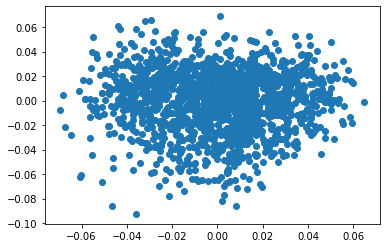

In [ ]:
plt.scatter(df['0'], df['1'])

I'm going to plot the farthest points from the origin and label them on the plot in order to get a sense of what these two latent factors may represent.

For each quadrant, I grab the indexes for the rows with the 5 largest distances and create a DataFrame from that and plot that data.

In [ ]:
def plot_top_5(df):
  # get the 5 points farthest from 0 from each quadrant
  idxs = np.array([])
  for quad in df['3'].unique():
    idxs = np.append(idxs, df[df['3']==quad]['2'].sort_values(ascending=False).index[:5].values)
  plot_df = df.loc[idxs]

  %matplotlib inline
  plt.rcParams['figure.figsize'] = [15, 15]

  # get the movie titles which will be plot annotations
  movies = dls.classes['title'][idxs]

  fig, ax = plt.subplots()

  ax.scatter(plot_df['0'], plot_df['1'])
  for i, idx in enumerate(idxs):
    ax.annotate(movies[i], (plot_df.loc[idx,'0'], plot_df.loc[idx, '1']))

  plt.show()

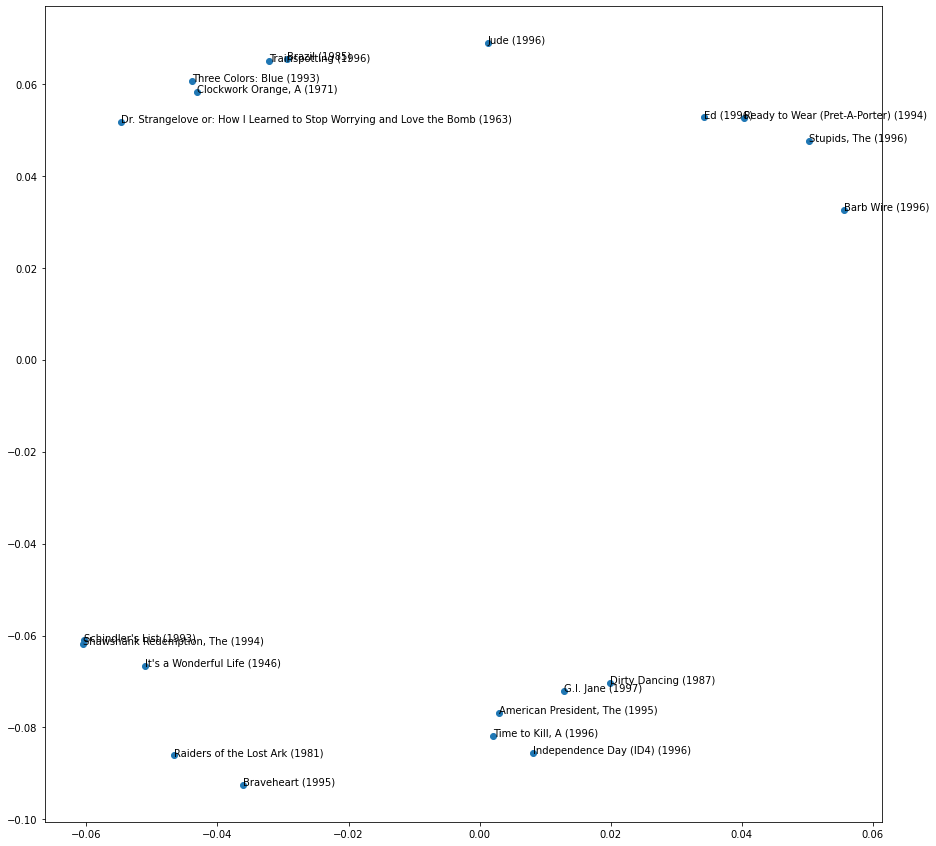

In [ ]:
plot_top_5(df)


The first quadrant seems to represent comedies (Ed, Ready to Wear, The Stupids) although Barb Wire is not a comedy.

The second quadrant has movies with some more dark and disturbing elements to it.

The third quadrant has movies which are drama and I guess share some theme of gaining freedom? 

Finally, the fourth quadrant seems to have drama and action movies which have a distinct American storyline to them. I haven't seen all of these movies, but Dirty Dancing and The American President seem like anomalies in this group. 

I should also take a look at other movies that do not fall on the extreme ends of each quadrant. For example, which movies fall close to the vertical and horizontal axes?

In [ ]:
def plot_close_to_axes(df):
  # get 5 points closes to each axis 
  idxs = np.array([])
  for key in ['0', '1']:
    idxs = np.append(idxs, df[np.abs(df[key]) < 0.0002].index.values)
  plot_df = df.loc[idxs]
  plot_df = plot_df.drop_duplicates()

  # set figure size
  %matplotlib inline
  plt.rcParams['figure.figsize'] = [15, 15]

  # get the movie titles which will be plot annotations
  movies = dls.classes['title'][idxs]

  fig, ax = plt.subplots()

  ax.scatter(plot_df['0'], plot_df['1'])

  # annotate with movie titles
  for i, idx in enumerate(idxs):
    ax.annotate(movies[i], (plot_df.loc[idx,'0'], plot_df.loc[idx, '1']))

  plt.show()

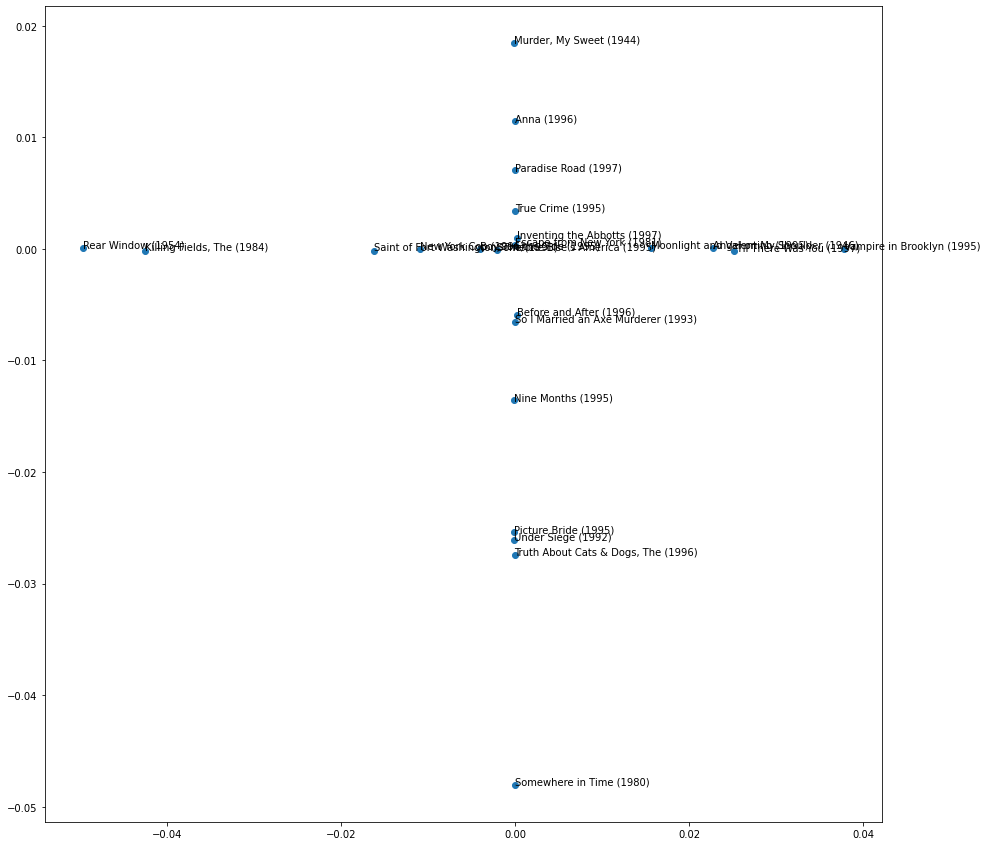

In [ ]:
plot_close_to_axes(df)

The latent factor corresponding to the vertical axis seems to represent drama (positive values) and romance (negative values) whereas the horizontal axis represents elements mystery (negative values) and comedy (positive values). However, I could just be focusing on genre whereas there are other features of a movie these may represent. Unfortunately, I'm not a movie buff, so the need for a domain expert is evident here!

##### Robust PCA

Although it's out of scope for this chapter and my understanding, I'd like to at least experiment with using Robust PCA for visualizing embeddings. Robust PCA is an algorithm which decomposes a matrix M into two components: a low rank matrix L and a sparse matrix S such that M = L + S. From what I understand, the sparse matrix S contains anomalies or outliers or "corrupted" data, whereas L contains a more accurate representation of the original data. For example, if an image has some additional noise added to it, the original image matrix M can be decomposed into a noise-less "clean" image L and a sparse noise matrix S. Another example is if you have an image with a background (such as a landscape with lawn, sidewalks, buildings) and a foreground (people walking on the sidewalk) passing that image through the RPCA algorithm would yield a background matrix L with the lawn, sidewalk and buildings and a foreground sparse matrix S with the people. Since my `movie_embeddings` matrix may contain anomalies which would affect the effectiveness and accuracy of my 2-component PCA approximation, I will pass it through a RPCA algorithm and calculate the 2-component approximation on the low-rank L and sparse S matrices and compare the results with what I calculated above.

The following algorithm is from Rachel Thomas' lesson on RPCA as part of her Computational Linear Algebra course.

In [ ]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca

In [ ]:
TOL=1e-9
MAX_ITERS=3

In [ ]:
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

In [ ]:
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

In [ ]:
def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

In [ ]:
def norm_op(M): return _svd(M, 1)[1][0]

In [ ]:
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [ ]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

In [ ]:
L, S, examples = pcp(movie_embeddings)

In [ ]:
L.shape, S.shape

I'll calculate 2-component PCA for the `L` and `S` matrices and plot those to see how they compare to the plots above.

In [ ]:
U_L, _, _ = fbpca.pca(L, k=2)
U_S, _, _ = fbpca.pca(S, k=2)

I exported the outputs to CSV for repeatability, so I'll import them in again:

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/fastai-course-v4/movies_L_pca.csv")
df.head()

,0,1,2,3
0,0.009254,-0.003454,0.009877,Fourth Quadrant
1,0.032954,0.008637,0.034067,First Quadrant
2,-0.014662,-0.047128,0.049356,Third Quadrant
3,0.012602,0.029182,0.031787,First Quadrant
4,-0.037841,0.008742,0.038838,Second Quadrant


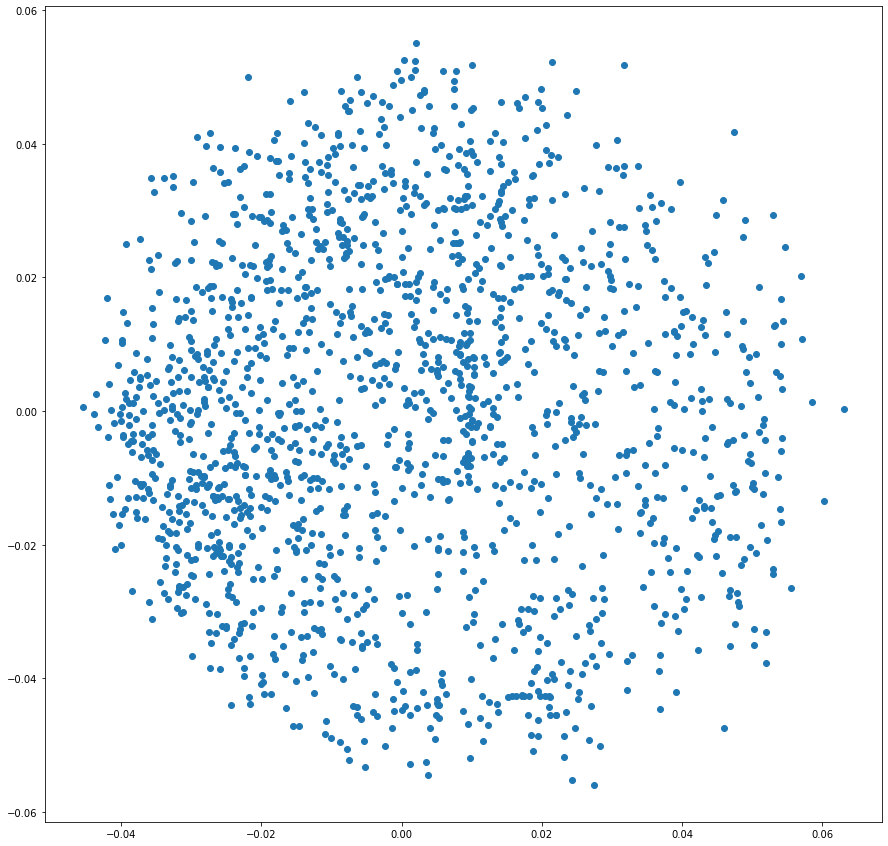

In [ ]:
plt.scatter(df['0'], df['1'])

The scatter plot for the 2-component PCA result seems much more evenly distributed across the quadrants.

I take the 5 farthest movies from each quadrant and plot those separately.

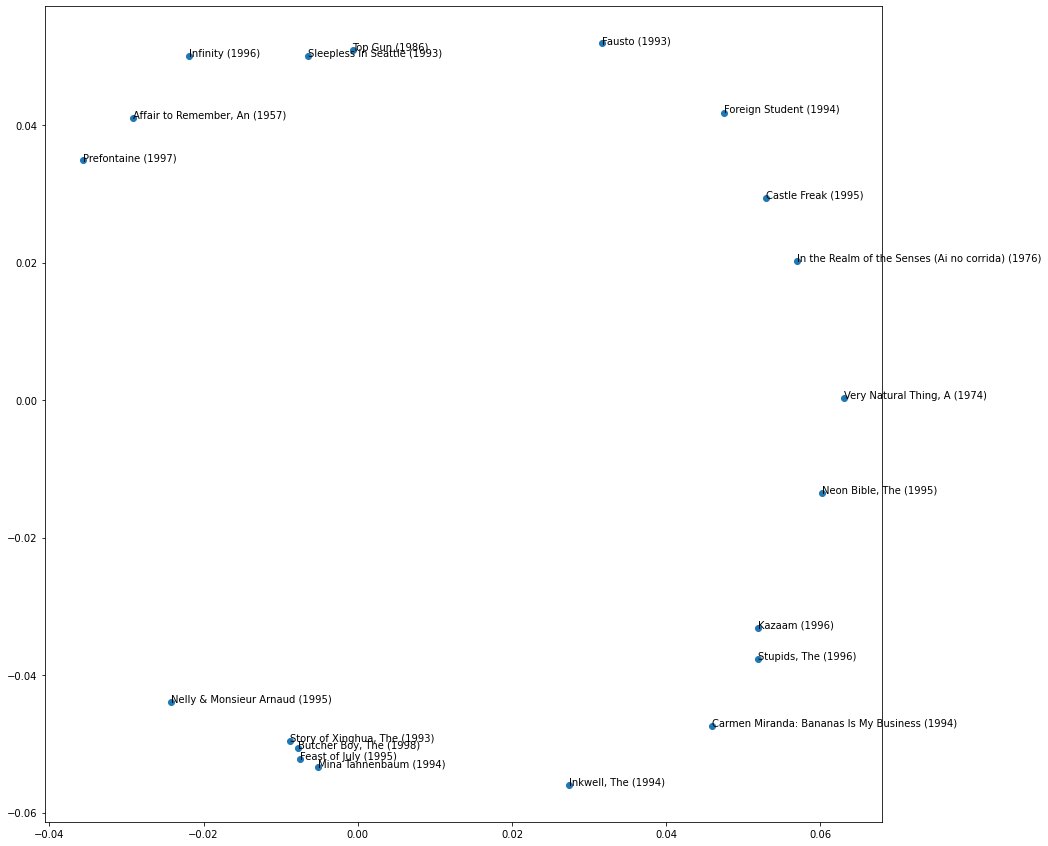

In [ ]:
plot_top_5(df)

Here are the patterns I observe. Again, someone who has watched these movies and is not just reading online descriptions of them would see themes and patterns that I would not.

|Quadrant|Observation|
|:-:|:-:|
|1|Romance/Drama movies. Fausto and Castle Freak seem out of place|
|2|More romance movies. Top Gun and Prefontaine seem out of place|
|3|More romance movies. The Butcher Boy seems out of place.|
|4|Comedies. The Carmen Miranda documentary seems out of place.|

After making these observations, either the low-rank matrix L is a poor choice to use for this type of analysis, or my understanding these movies is too shallow to see the deeper relationships between them. With so many romance movies across the plot, I don't think these latent factors represent genres.

I'm not too confident the `S` matrix will provide more clarity, but let's see!

In [ ]:
# import previously generated CSV
df = pd.read_csv("/content/gdrive/MyDrive/fastai-course-v4/movies_S_pca.csv")
df.head()

,0,1,2,3
0,-0.009776,0.005041,0.010999,Second Quadrant
1,-0.021503,0.001765,0.021576,Second Quadrant
2,0.005098,0.024645,0.025166,First Quadrant
3,-0.016745,-0.021457,0.027218,Third Quadrant
4,0.056964,-0.023095,0.061467,Fourth Quadrant


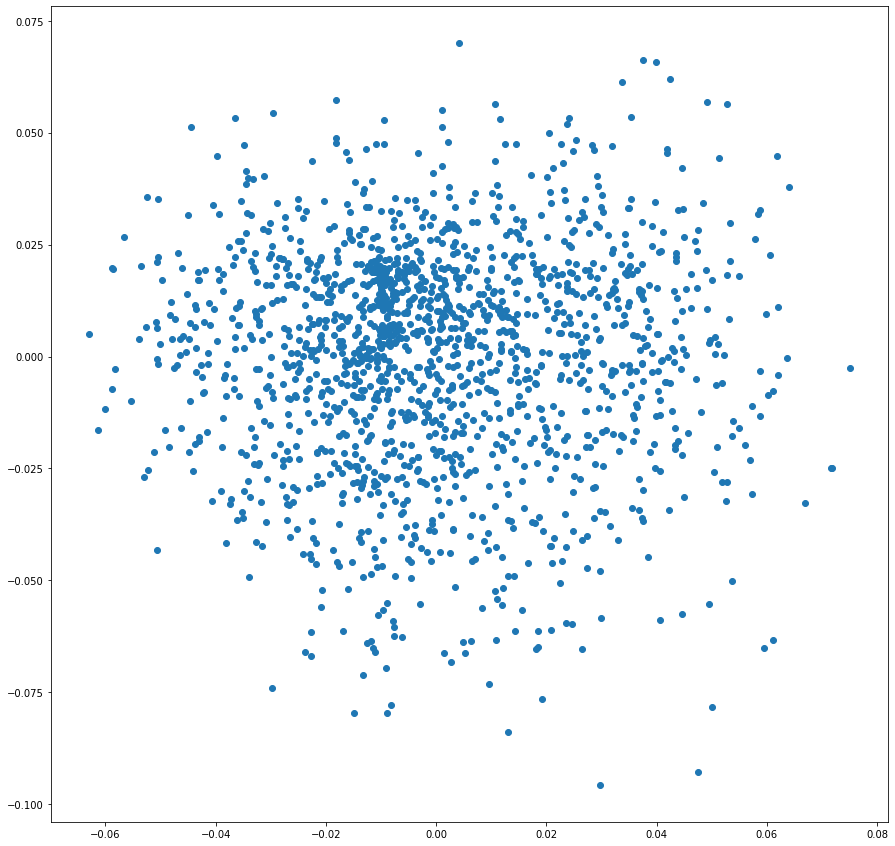

In [ ]:
plt.scatter(df['0'], df['1'])

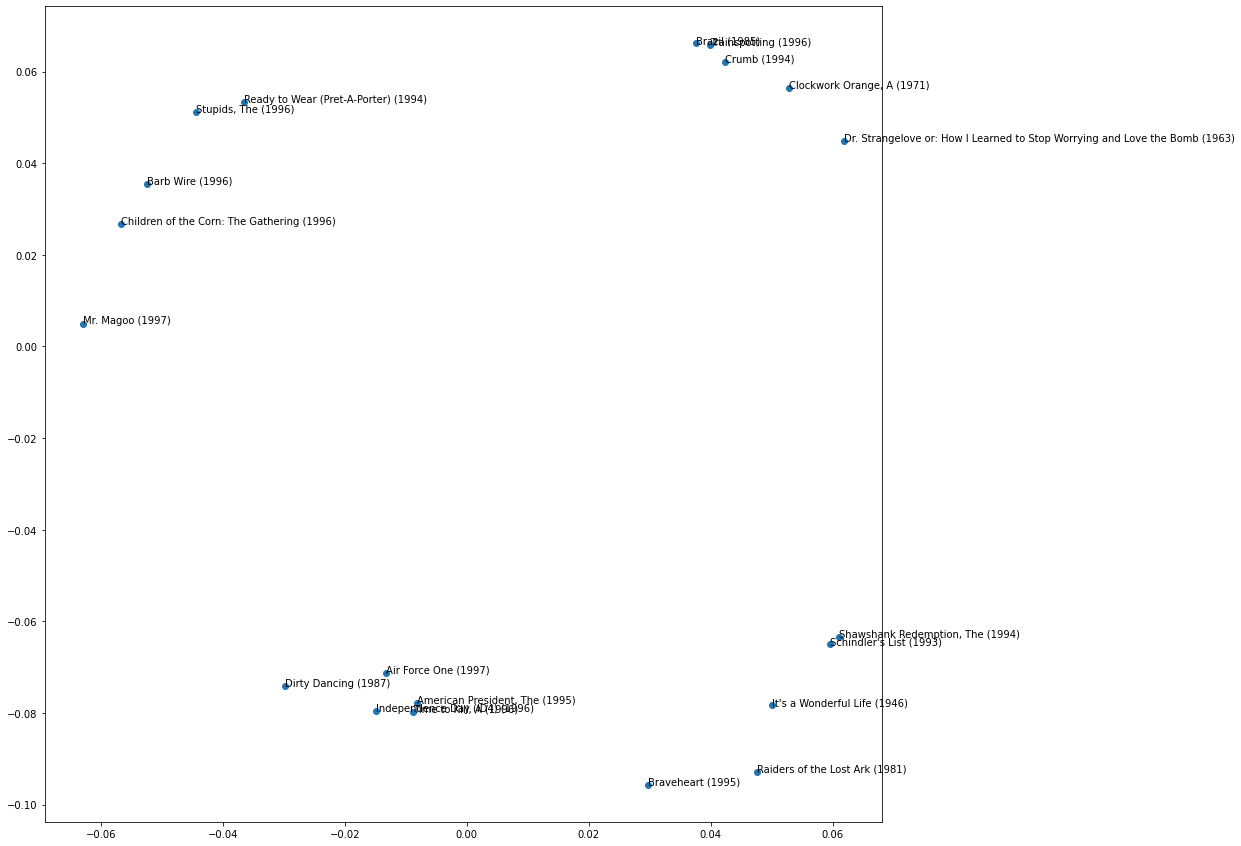

In [ ]:
plot_top_5(df)

Interesting! This plot looks like the plot of the original M matrix PCA results reflected across the y-axis. Similar movies are grouped together but the latent factors are showing an inverse relationship to the original 2-components. 

#### Using fastai.collab

fastai comes with a built-in method to create a collaborative filtering model similar to the `DotProductBias` model I created.

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932735,0.930009,00:10
1,0.834800,0.862961,00:11
2,0.746893,0.822192,00:10
3,0.585107,0.811398,00:10
4,0.490022,0.812597,00:10


This yields similar results to what I've done above. Here are this model's results:

In [ ]:
learn.show_results()

,user,title,rating,rating_pred
0,541,332,1,2.542970
1,899,1295,4,3.555057
2,346,1492,3,3.456876
3,933,1399,4,3.380442
4,310,1618,5,4.623110
5,276,1572,4,3.636531
6,463,322,5,3.901797
7,130,408,4,3.343735
8,914,1617,4,3.076288


The model created is a `EmbeddingDotBias` model

In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

The top biases can be obtained similar to how we did it before, but with a slightly different API:

In [ ]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Star Wars (1977)',
 "Schindler's List (1993)"]

Similar to the `distance` function I created, PyTorch has a `nn.CosineSimilarity` function which calculates the cosine of the angle between two vectors. The smaller the angle, the closer the two points are, and the more similar they are. `nn.CosineSimilarity` returns the similarity (cosine of the angle) between two vectors where `1.000` means the angle is 0. 

In [ ]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
similarity = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = similarity.argsort(descending=True)[1]
dls.classes['title'][idx]

'Some Folks Call It a Sling Blade (1993)'

### Deep Learning for Collaborative Filtering

In this final section, we create a Deep Learning model which can make predictions on movie ratings after training on the MovieLens dataset. The model uses Embeddings (for users and movies) which are then fed into a small neural net (with one ReLu sandwiched between two Linear layers) which outputs an activation which we normalize using `sigmoid_range`. The embedding matrices are sized based on a heuristic built-in to fastai with the `get_emb_sz` method:

In [ ]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

The model used is constructed as follows: the user and item latent factors are created using `Embedding`s, and the neural net is created using the `nn.Sequential` class. Each time a prediction is needed, the user and item matrices for one batch are concatenated and passed through the neural net. The returned activation is sent to `sigmoid_range` and a prediction between 0 and 5.5 is calculated.

In [ ]:
class CollabNN(Module):
  def __init__(self, user_sz, item_sz, y_range=(0, 5.5), n_act=100):
    self.user_factors = Embedding(*user_sz)
    self.item_factors = Embedding(*item_sz)
    self.layers = nn.Sequential(
        nn.Linear(user_sz[1]+item_sz[1], n_act),
        nn.ReLU(),
        nn.Linear(n_act, 1))
    self.y_range = y_range

  def forward(self, x):
    embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
    x = self.layers(torch.cat(embs, dim=1))
    return sigmoid_range(x, *self.y_range)

I want to visualize the `forward` method, so I'll create the model and a batch, and walkthrough the code.

In [ ]:
model = CollabNN(*embs)
x,y = dls.one_batch()
device = "cpu"
x = x.to(device)
model = model.to(device)
embs = torch.cat((model.user_factors(x[:,0]), model.item_factors(x[:,1])), dim=1)
embs.shape

torch.Size([64, 176])

In [ ]:
x = model.layers(embs)
sigmoid_range(x, *model.y_range)[:5]

tensor([[2.8637],
        [2.8647],
        [2.8624],
        [2.8696],
        [2.8601]], grad_fn=<SliceBackward>)

The fastai `collab_learner`, instead of using the `EmbeddingDotBias` model, will use a neural network if passed `True` for its `use_nn` parameter. The number and size of neural network layers can also be specified.



In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.988426,0.984418,00:15
1,0.893442,0.909180,00:16
2,0.900106,0.877499,00:16
3,0.809255,0.853736,00:16
4,0.769467,0.853571,00:16


In [ ]:
learn.show_results()

,user,title,rating,rating_pred
0,244,1305,4,4.185966
1,902,965,3,3.474954
2,87,1173,5,4.206645
3,759,333,5,4.247213
4,109,1624,3,3.726794
5,363,743,1,1.774737
6,756,1216,5,4.058509
7,378,179,4,3.192873
8,18,141,3,3.296141


In [ ]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

The `EmbeddingNN` architecture extends the `TabularModel` class which we will explore in Chapter 9.

That finishes my review of Chapter 8, I'll be working through the "Further Research" section in upcoming blog posts and associated videos:

> 1. Take a look at all the differences between the `Embedding` version of `DotProductBias` and the `create_params` version, and try to understand why each of those changes is required. If you're not sure, try reverting each change to see what happens.

> 2. Find three other areas where collaborative filtering is being used, and identify the pros and cons of this approach in those areas.

> 3. Complete this notebook using the full MovieLens dataset, and compare your results to online benchmarks. See if you can improve your accuracy. Look on the book's website and the fast.ai forums for ideas. Note that there are more columns in the full dataset--see if you can use those too (the next chapter might give you ideas).

> 4. Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.